Evaluation metric: 'The RMSE between log of Saleprice and log of prediction'. Need to convert salesprice to log value first. However seems that BoxCox does a better job here. And the final values (~ .1) are too low to be rmsle... 

Original competition (explains the evaluation metric): https://www.kaggle.com/c/home-data-for-ml-course/overview/evaluation
My submission on that site is 33 out of 38000, top .08%

Original notebook source: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

reference for good ideas:
    https://towardsdatascience.com/tricks-i-used-to-succeed-on-a-famous-kaggle-competition-adaa16c09f22

original default score was .11543, new best score is 0.11353

#Stacked and Ensembled Regressions to predict House Prices

How to Kaggle: https://www.youtube.com/watch?v=GJBOMWpLpTQ

##Donald S

**June 2020**

Need to submit every 2 months as the leaderboard will rollover after this 2 month period



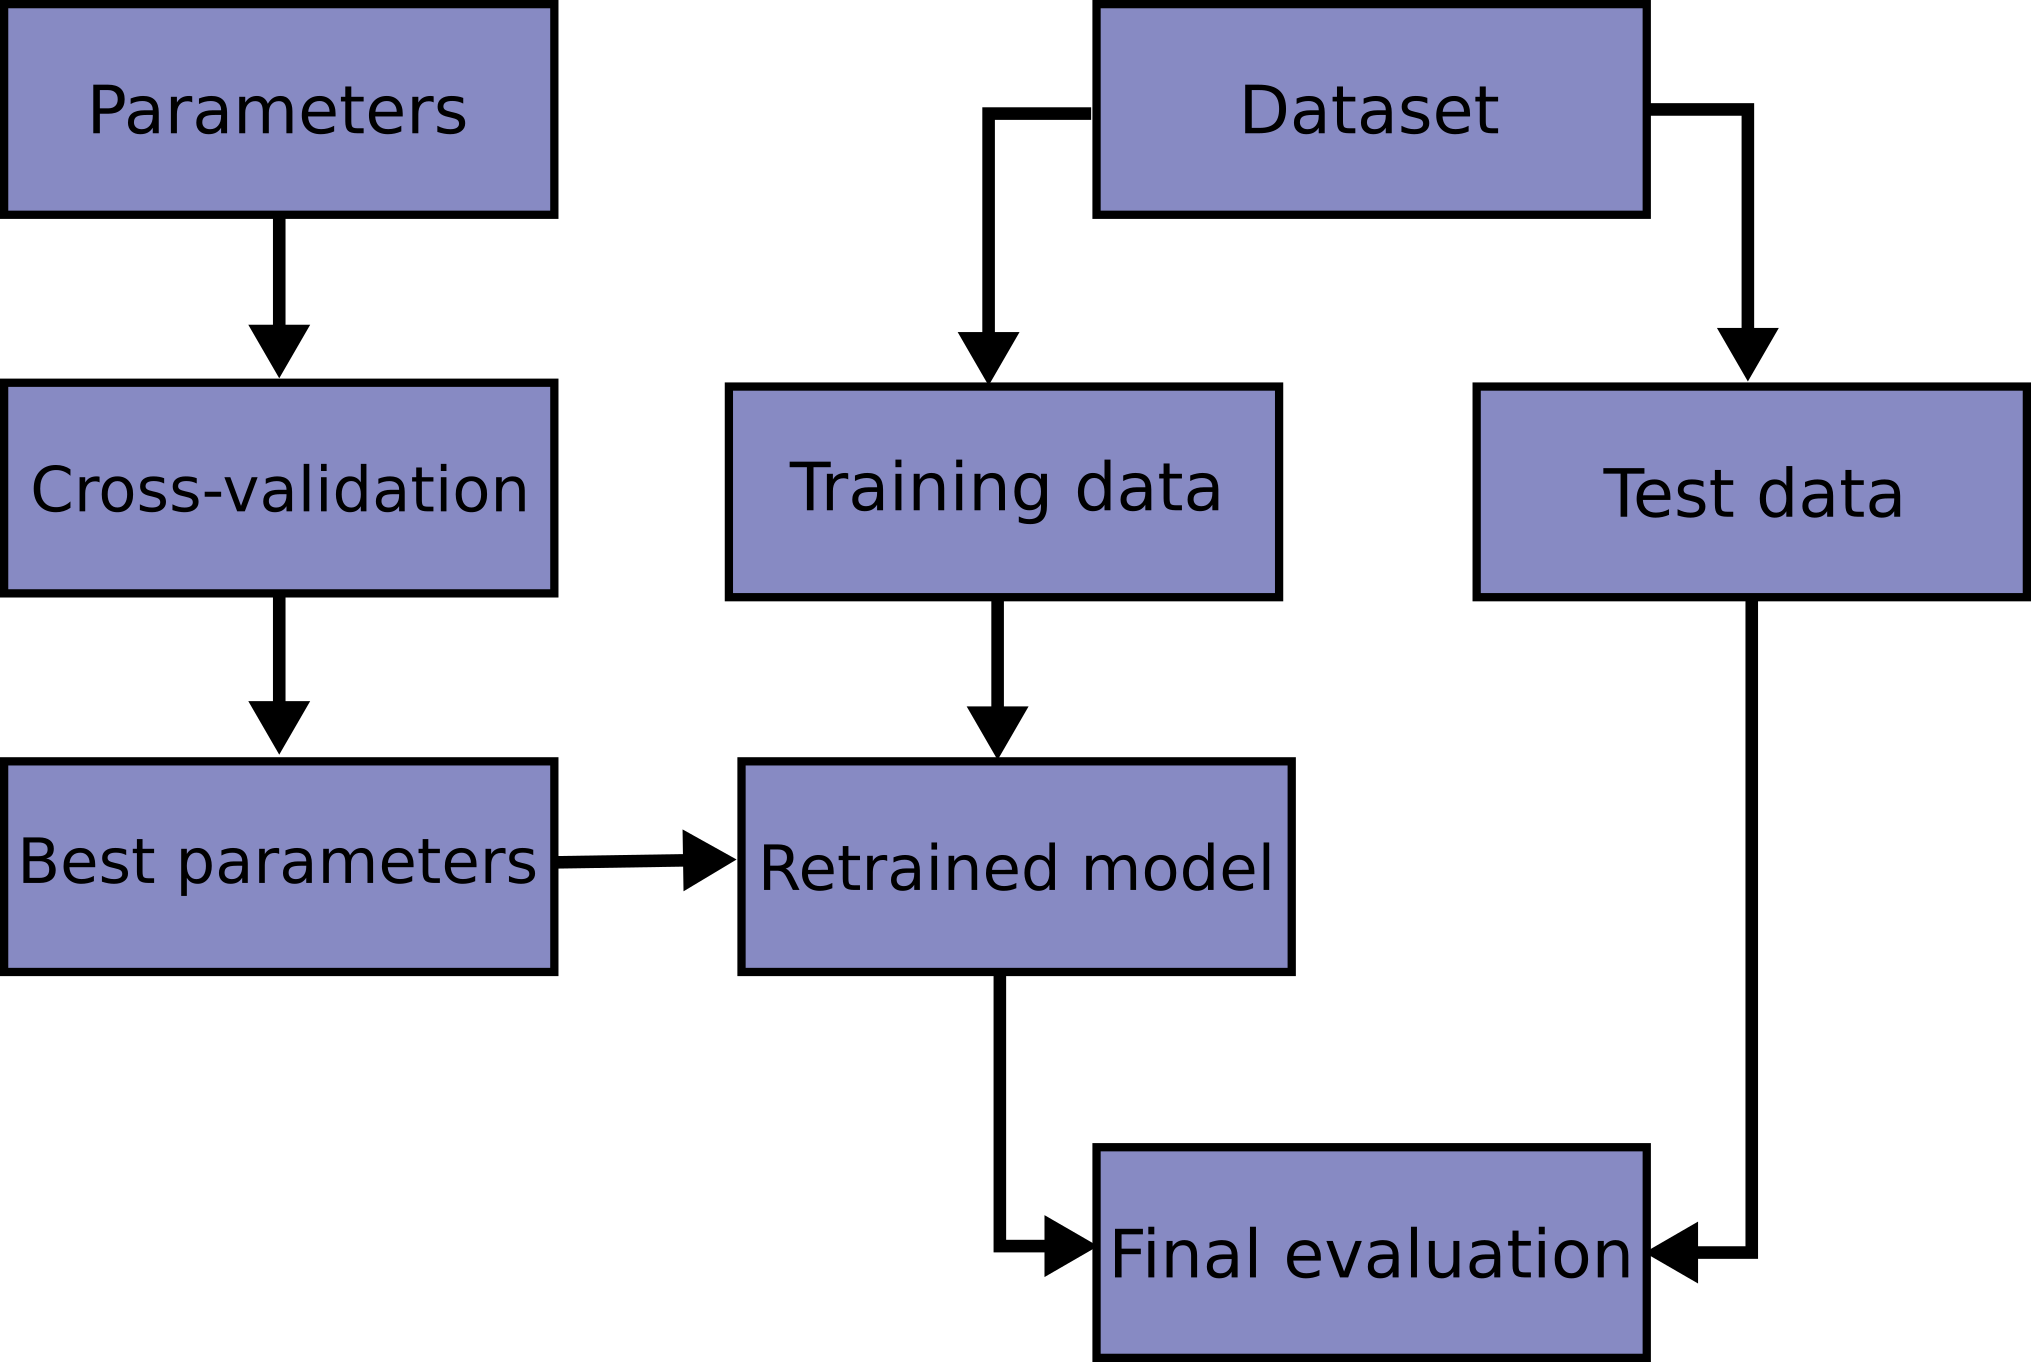

comments from the original author:

This competition is very important to me as  it helped me to begin my journey on Kaggle few months ago. I've read  some great notebooks here. To name a few:

1. [Comprehensive data exploration with Python][1] by **Pedro Marcelino**  : Great and very motivational data analysis

2. [A study on Regression applied to the Ames dataset][2] by **Julien Cohen-Solal**  : Thorough features engeneering and deep dive into linear regression analysis  but really easy to follow for beginners.

3. [Regularized Linear Models][3] by **Alexandru Papiu**  : Great Starter kernel on modelling and Cross-validation

I can't recommend enough every beginner to go carefully through these kernels (and of course through many others great kernels) and get their first insights in data science and kaggle competitions.

After that (and some basic pratices) you should be more confident to go through [this great script][7] by **Human Analog**  who did an impressive work on features engeneering. 

As the dataset is particularly handy, I  decided few days ago to get back in this competition and apply things I learnt so far, especially stacking models. For that purpose, we build two stacking classes  ( the simplest approach and a less simple one). 

As these classes are written for general purpose, you can easily adapt them and/or extend them for your regression problems. 
The overall approach is  hopefully concise and easy to follow.. 

The features engeneering is rather parsimonious (at least compared to some others great scripts) . It is pretty much :

- **Imputing missing values**  by proceeding sequentially through the data

- **Transforming** some numerical variables that seem really categorical

- **Label Encoding** some categorical variables that may contain information in their ordering set

-  [**Box Cox Transformation**][4] of skewed features (instead of log-transformation) : This gave me a **slightly better result** both on leaderboard and cross-validation.

- ** Getting dummy variables** for categorical features. 

Then we choose many base models (mostly sklearn based models + sklearn API of  DMLC's [XGBoost][5] and Microsoft's [LightGBM][6]), cross-validate them on the data before stacking/ensembling them. The key here is to make the (linear) models robust to outliers. This improved the result both on LB and cross-validation. 

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

To my surprise, this does well on LB ( 0.11420 and top 4% the last time I tested it : **July 2, 2017** )



**Hope that at the end of this notebook, stacking will be clear for those, like myself, who found the concept not so easy to grasp**

In [ ]:
#import some necessary libraries
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import time

from scipy import stats
from scipy.stats import norm, skew, kurtosis, boxcox #for some statistics
from scipy.special import boxcox1p, inv_boxcox
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

StartTime = datetime.datetime.now()

In [ ]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

In [ ]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')


In [ ]:
##display the first five rows of the train dataset.
train.head(5)

In [ ]:
##display the first five rows of the test dataset.
test.head(5)


In [ ]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

#Data Processing

##Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


In [ ]:
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice']
ax.scatter(x = train['GrLivArea'], y = np.log(train['SalePrice']))
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

#m, b = np.polyfit(train['GrLivArea'], train['SalePrice'], 1)
m, b = np.polyfit(train['GrLivArea'], np.log(train['SalePrice']), 1)
#m = slope, b=intercept
plt.plot(train['GrLivArea'], m*train['GrLivArea'] + b)

plt.show()


Edit: Look for fliers in other columns

In [ ]:
train.shape[1]
#a = int(np.sqrt(train.shape[1]))
a = 4
b = int(train.shape[1]/4)
r = int(train.shape[1]/a)
c = int(train.shape[1]/b)
i = 0
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(15, 60))
for row in ax:
    for col in row:
        #print(train.columns[i])
        #print(train[train.columns[i]].dtype)
        #col.plot()
        #ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
        try:
            #col.scatter(x = train[train.columns[i]], y = train['SalePrice'])
            col.scatter(x = train[train.columns[i]], y = np.log(train['SalePrice']))
            col.title.set_text(train.columns[i])
            #col.title(train.columns[i])
        except:
            temp=1
        #except Exception as e:
        #    print(e.message, e.args)
        finally:
            temp=1
        i = i + 1
        
plt.show()

More filtering of data to try

In [ ]:

#train = train.drop(train[(train['LotFrontage']>300) & (train['SalePrice']<400000)].index)
#train = train.drop(train[(train['LotArea']>100000) & (train['SalePrice']<400000)].index)
#train = train.drop(train[(train['BsmtFinSF1']>4000) & (train['SalePrice']<250000)].index)
#train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)

#haven't tried this one yet
train = train.drop(train[(train['OverallQual']>9) & (train['SalePrice']<220000)].index)


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

Edit: Think this deletion is safe to do as there are only 2 points and they seem to be abnormal, possibly data error

In [ ]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
#ax.scatter(train['GrLivArea'], train['SalePrice'])
ax.scatter(train['GrLivArea'], np.log(train['SalePrice']))
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
#m, b = np.polyfit(train['GrLivArea'], train['SalePrice'], 1)
m, b = np.polyfit(train['GrLivArea'], np.log(train['SalePrice']), 1)
#m = slope, b=intercept
plt.plot(train['GrLivArea'], m*train['GrLivArea'] + b)
plt.show()

###Note : 
 Outliers removal is note always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

Edit: todo - look for other outliers in all columns. Maybe better to use StandardScaler() and np.clip

##Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.

In [ ]:
sns.distplot(train['SalePrice'] , fit=norm)

_skew = skew(train['SalePrice'])
_kurtosis = kurtosis(train['SalePrice'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}, skew = {:.2f} kurtosis = {:.2f}\n'.format(mu, sigma, _skew, _kurtosis))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.


**Tansformation of the target variable**
 
Default is to use log1p as this is included in the evaluation metric, rmsle 
Edit: also trying box-cox transform.
The Box-Cox transform is given by:
<pre>
y = (x**lmbda - 1) / lmbda,  for lmbda > 0  
    log(x),                  for lmbda = 0

In [ ]:
#We try the numpy function log1p which  applies log(1+x) to all elements of the column

# option 1 - original
#train["SalePrice"] = np.log1p(train["SalePrice"])

# Option 2: use box-cox transform - this performs worse than the log(1+x), reverting back...now it seems to be scoring better. Maybe my earlier evaluation was incorrect
# try different alpha values  between 0 and 1
lam_l = 0.35
train["SalePrice"] = boxcox1p(train["SalePrice"], lam_l) 

# Option 3: boxcox letting the algorithm select lmbda based on least-likelihood calculation
#train["SalePrice"], lam_l = boxcox(x=train["SalePrice"], lmbda=None)

# option 4 - compare to log1p => score is same
#train["SalePrice"] = np.log(train["SalePrice"])

Here is the difference between BoxCox and Log values, the difference is substantial at the value of a house

In [ ]:
x = np.linspace(0, 20)
y1 = np.log(x)
y2 = np.log1p(x)
y3 = boxcox1p(x, 0.35)
y4 = boxcox1p(x, 0.10)
y5 = boxcox1p(x, 0.50)
plt.plot(x,y1,label='log') 
plt.plot(x,y2,label='log1p') 
plt.plot(x,y3,label='boxcox .35') 
plt.plot(x,y4,label='boxcox .10') 
plt.plot(x,y5,label='boxcox .50') 
plt.legend()
plt.show()

x = np.linspace(0, 100000)
y1 = np.log(x)
y2 = np.log1p(x)
y3 = boxcox1p(x, 0.35)
y4 = boxcox1p(x, 0.10)
y5 = boxcox1p(x, 0.50)
plt.plot(x,y1,label='log') 
plt.plot(x,y2,label='log1p') 
plt.plot(x,y3,label='boxcox .35') 
plt.plot(x,y4,label='boxcox .10') 
plt.plot(x,y5,label='boxcox .50') 
plt.legend()
plt.show()

In [ ]:
# to revert back use y = inv_boxcox(x, lam_l) => train["SalePrice"] = inv_boxcox(train["SalePrice"], lam_l)
# think the underlying formula is this: # pred_y = np.power((y_box * lambda_) + 1, 1 / lambda_) - 1

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

_skew = skew(train['SalePrice'])
_kurtosis = kurtosis(train['SalePrice'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}, skew = {:.2f} kurtosis = {:.2f}\n'.format(mu, sigma, _skew, _kurtosis))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The skew seems now corrected and the data appears more normally distributed. 

Edit: Both distributions have a positive kurtosis, which means there is a steep dropoff in the curve from the center, or the tails have few points. Skewness is close to 0 now, so that metric is closer to a normal distribution

##Features engineering

let's first  concatenate the train and test data in the same dataframe

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

In [ ]:
all_data.head()

###Missing Data

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


Cross Correlation chart to view collinearity within the features. Kendall's seems appropriate as the Output Variable is numerical and much of the input is categorical. Here is a chart to guide you to which method to use based on your dataset.

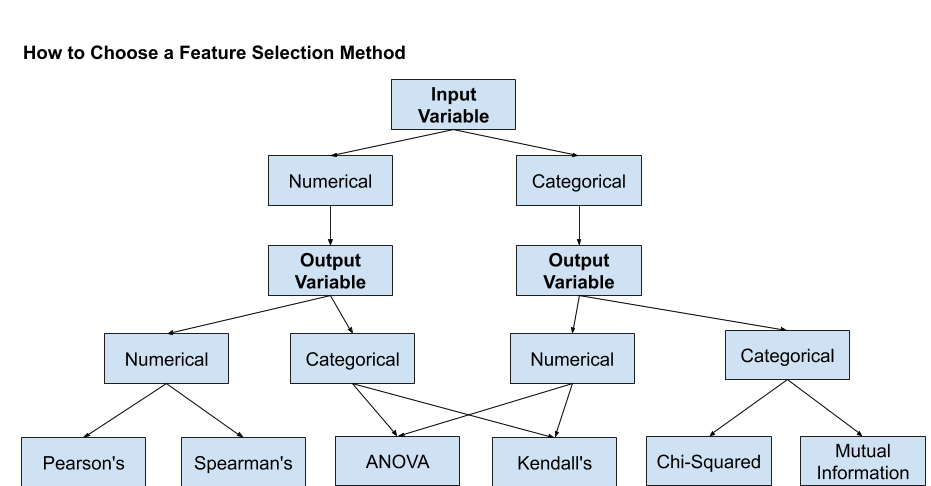

In [ ]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = train.corr(method='kendall')
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

###Imputing missing values 

We impute them  by proceeding sequentially  through features with missing values 

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [ ]:
all_data.dtypes

- **MiscFeature** : data description says NA means "no misc feature"


In [ ]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley** : data description says NA means "no alley access"

In [ ]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence** : data description says NA means "no fence"

In [ ]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu** : data description says NA means "no fireplace"

In [ ]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [ ]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.


In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [ ]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [ ]:
all_data['MSZoning'].value_counts()

In [ ]:
# this one may be a bit dangerous, maybe try to get zone from neighborhood most common value, similar to LotFrontage previously
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [ ]:
all_data['Utilities'].value_counts()

In [ ]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [ ]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [ ]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [ ]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [ ]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [ ]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [ ]:

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



Is there any remaining missing value ? 

In [ ]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

It remains no missing value.


###More features engeneering

**Transforming some numerical variables that are really categorical**

Edit: I will add a new column year and date as ordinal, since there is some order to the values it may be useful

In [ ]:
all_data['MSSubClass'].value_counts()


In [ ]:
all_data['OverallCond'].value_counts()

In [ ]:
all_data.shape

Want to add ordinal or int column for Year and Month, this is the function to perform that task

In [ ]:
import datetime
Yr = all_data['YrSold'].min()
Mo = all_data['MoSold'].min()
t = datetime.datetime(Yr, Mo, 1, 0, 0)

def calculateYrMo (row):   
    return int((datetime.datetime(row.YrSold,row.MoSold,1) - t).total_seconds())

In [ ]:
# either way will work
#all_data['YrMoSold'] = all_data.apply(lambda row: int((datetime.datetime(row.YrSold,row.MoSold,1) - t).total_seconds()), axis=1)

all_data['YrMoSold'] = all_data.apply(lambda row: calculateYrMo(row), axis=1)

In [ ]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


**Label Encoding some categorical variables that may contain information in their ordering set** 

**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [ ]:
from sklearn.preprocessing import LabelEncoder
#cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
#        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
#        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
#        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
#        'YrSold', 'MoSold', 'YrMoSold')

# Edit: Dropping PoolQC for missing values => makes the model worse, reverting
#all_data = all_data.drop(['PoolQC'], axis=1)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'YrMoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))


In [ ]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


**Skewed features**

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index

lam_f = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam_f)
    
    #all_data[skewed_features] = np.log1p(all_data[skewed_features])

I recommend plotting the cumulative sum of eigenvalues (assuming they are in descending order). If you divide each value by the total sum of eigenvalues prior to plotting, then your plot will show the fraction of total variance retained vs. number of eigenvalues. The plot will then provide a good indication of when you hit the point of diminishing returns (i.e., little variance is gained by retaining additional eigenvalues).

**Getting dummy categorical features**

In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

Do some PCA for the dataset, to remove some of the collinearity. Not sure if this will have any effect as collinearity is usually not detrimental to many or most algorithms

In [ ]:
# to choose number of components, look at this chart. Reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
from sklearn.decomposition import PCA

pca = PCA().fit(all_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

 We choose number of eigenvalues to calculate based on previous chart, 20 looks like a good number, the chart starts to roll off around 15 and almost hits max a 20. We can also try 30,40 and 50 to squeeze a little more variance out...

In [ ]:
#do PCA/StandardScaler+clip here or before the skew boxcox1p transform

n_components = 50
pca = PCA(n_components=n_components)
all_data_pca = pca.fit_transform(all_data)

our column count went from 216 to n_component value

In [ ]:
print(all_data.shape)
print(all_data_pca.shape)

Edit: pca.components_ is the matrix you can use to calculate the inverse of the PCA analysis, i.e. go back to the original dataset
reference: https://stats.stackexchange.com/a/143949

In [ ]:
weights = np.round(pca.components_, 3) 
ev = np.round(pca.explained_variance_ratio_, 3)
print('explained variance ratio',ev)
pca_wt = pd.DataFrame(weights)#, columns=all_data.columns)
pca_wt.head()

The shape values are the number of columns in the PCA x the number of original columns

In [ ]:
pca_wt.shape 

In [ ]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = pd.DataFrame(all_data_pca).corr(method='kendall')
plt.subplots(figsize=(12,9))
plt.title("Kendall's Correlation Matrix PCA applied", fontsize=16)
sns.heatmap(corrmat, vmax=0.9, square=True)


#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = train.corr(method='kendall')
plt.subplots(figsize=(12,9))
plt.title("Kendall's Correlation Matrix Initial Train Set", fontsize=16)
sns.heatmap(corrmat, vmax=0.9, square=True);


As you can see, the PCA analysis did its job, the features show little correlation now

Another look at the feature to output correlations

In [ ]:
a=''' not working now
correlations = corrmat["SalePrice"].sort_values(ascending=False)
features = correlations.index[0:10]

sns.pairplot(train[features], size = 2.5)
plt.show();'''

Getting the new train and test sets. 

In [ ]:
print(type(all_data))
print(type(pd.DataFrame(all_data_pca)))

Testing the new PCA dataset for analysis - RMSE looks works after PCA is applied, need to look at the Kaggle score later and see if it correlates, could be a mistake to use PCA on categorical dummy data. However, XGB is better with PCA n=50 option. Maybe use a heavier weight for that portion, or use all_data_pca only on that model...

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
rc = RobustScaler()

use_pca = 0 # using PCA currently hurts the score
use_normalization = 0 # using StandardScaler doesn't work, try RobustScaler now

if (use_pca == 1):
    all_data_pca = pd.DataFrame(all_data_pca)
    train = all_data_pca[:ntrain]
    test = all_data_pca[ntrain:]
    all_data_pca.head()
elif (use_normalization == 1):
    train = all_data[:ntrain]
    test = all_data[ntrain:]
    scaled_features = sc.fit_transform(train.values)
    train = pd.DataFrame(scaled_features, index=train.index, columns=train.columns)
    scaled_features = sc.transform(test.values)
    test = pd.DataFrame(scaled_features, index=test.index, columns=test.columns)   
elif (use_normalization == 2):
    train = all_data[:ntrain]
    test = all_data[ntrain:]
    scaled_features = rc.fit_transform(train.values)
    train = pd.DataFrame(scaled_features, index=train.index, columns=train.columns)
    scaled_features = rc.transform(test.values)
    test = pd.DataFrame(scaled_features, index=test.index, columns=test.columns)  
else:
    # back to original splits (from train.csv and test.csv)
    train = all_data[:ntrain]
    test = all_data[ntrain:]


#Modelling

**Import libraries**

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_squared_log_error
# to run locally: conda install -c anaconda py-xgboost
import xgboost as xgb
import lightgbm as lgb


**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code,  in order to shuffle the dataset  prior to cross-validation

replace cross_val_score() with cross_validate()
# reference: https://scikit-learn.org/stable/modules/cross_validation.html

>>> from sklearn.metrics import make_scorer
>>> scoring = {'prec_macro': 'precision_macro',
...            'rec_macro': make_scorer(recall_score, average='macro')}
>>> scores = cross_validate(clf, X, y, scoring=scoring,
...                         cv=5, return_train_score=True)
>>> sorted(scores.keys())
['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro',
 'train_prec_macro', 'train_rec_macro']
>>> scores['train_rec_macro']
array([0.97..., 0.97..., 0.99..., 0.98..., 0.98...])

Kfold is useful for thorough testing of a model, will give a more accurate score based on remove some data test on the remaining and change the data removed each time. See image below for details:

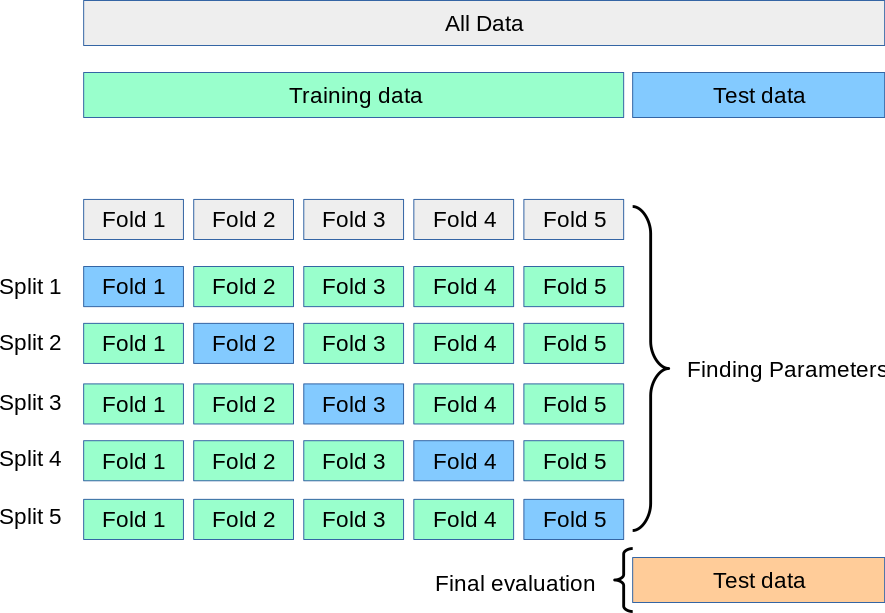

In [ ]:
#Validation function
# train.values and y_train are both log scaled so just need to take the square of the delta between them to calculate the error, then take the sqrt to get rmsle
# but for now y_train is boxcox1p(), not log(). Use this to convert back: inv_boxcox(y_train, lam_l)
n_folds=5 # was 5 => better score but twice as slow now

def rmsle_cv(model):
    print("running rmsle_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf)) # also r2
    print("raw rmse scores for each fold:", rmse)
    return(rmse)

In [ ]:
print(y_train.mean())
print(inv_boxcox(y_train, lam_l).mean())

##Base models

In [ ]:
def runGSCV(num_trials, features, y_values):
    non_nested_scores = np.zeros(num_trials) # INCREASES BIAS
    nested_scores = np.zeros(num_trials)
    # Loop for each trial
    for i in range(num_trials):
        print("Running GridSearchCV:")
        with MyTimer():    
            #grid_result = gsc.fit(train, y_train)  
            grid_result = gsc.fit(features, y_values)  
        non_nested_scores[i] = grid_result.best_score_
        print("Best rmse %f using %s" % ( np.sqrt(-grid_result.best_score_), grid_result.best_params_))
        # nested/non-nested cross validation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
        with MyTimer():    
            #nested_score = cross_val_score(gsc, X=train, y=y_train, cv=outer_cv, verbose=0).mean() 
            nested_score = cross_val_score(gsc, X=features, y=y_values, cv=outer_cv, verbose=0).mean() 
            # source code for cross_val_score is here: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py#L137
        print("nested rmse score from KFold %0.3f" % np.sqrt(-nested_score))
        nested_scores[i] = nested_score
        print('grid_result',grid_result)
        print("scores with BoxCox applied: r2(%0.3f) nmse(%0.3f) nmsle(%0.3f)" % (grid_result.cv_results_['mean_test_r2'].mean(),grid_result.cv_results_['mean_test_nmse'].mean(),grid_result.cv_results_['mean_test_nmsle'].mean()))
    return grid_result



List of possible scoring values:  
Regression  

‘explained_variance’ metrics.explained_variance_score  
‘max_error’ metrics.max_error  
‘neg_mean_absolute_error’ metrics.mean_absolute_error  
‘neg_mean_squared_error’ metrics.mean_squared_error  
‘neg_root_mean_squared_error’ metrics.mean_squared_error  
‘neg_mean_squared_log_error’ metrics.mean_squared_log_error  
‘neg_median_absolute_error’ metrics.median_absolute_error  
‘r2’ metrics.r2_score  
‘neg_mean_poisson_deviance’ metrics.mean_poisson_deviance  
‘neg_mean_gamma_deviance’ metrics.mean_gamma_deviance  

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline, also want to compare to StandardScaler() => RobustScaler() is slightly better

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1)) # was 1

- **Elastic Net Regression** :

again made robust to outliers

In [ ]:
# initialize the algorithm for the GridSearchCV function
ENet = ElasticNet()
tuningENet = 1 # takes 2 minutes to complete

if (tuningENet == 1):
    # use this when tuning
    param_grid={
        'alpha':[0.005,0.01,0.05,0.1],
        'l1_ratio':[.6,.65,.7,.75,.8],
        'fit_intercept':[True], # ,False
        'normalize':[False], # True,
        'max_iter':range(100,500,100),
        'selection':['random'] # 'cyclic',
    }

else:
    # use this when not tuning
    param_grid={
        'alpha':[0.01],
        'l1_ratio':[.75],
        'fit_intercept':[True],
        'normalize':[False],
        'max_iter':[100],
        'selection':['random']
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=ENet,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

In [ ]:
#ENet = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet = make_pipeline(StandardScaler(), ElasticNet(**grid_result.best_params_, random_state=3))


- **Kernel Ridge Regression** :

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Random Forest Regressor** :

This model needs improvement, will run cross validate on it

In [ ]:
# initialize the algorithm for the GridSearchCV function
rf = RandomForestRegressor()
tuningRF = 0 # this took 2 hours last time, 1 hour per iteration

if (tuningRF == 1):
    # use this when tuning
    param_grid={
        'max_depth':[3,4,5],
        'max_features':[None,'sqrt','log2'], 
        # 'max_features': range(50,401,50),
        # 'max_features': [50,100], # can be list or range or other
        'n_estimators':range(25,100,25), 
        #'class_weight':[None,'balanced'],  
        'min_samples_leaf':range(5,15,5), 
        'min_samples_split':range(10,30,10), 
        'criterion':['mse', 'mae'] 
    }

else:
    # use this when not tuning
    param_grid={
        'max_depth':[5],
        'max_features':[None], # max_features is None is default and works here, removing 'sqrt','log2'
        # 'max_features': range(50,401,50),
        # 'max_features': [50,100], # can be list or range or other
        'n_estimators': [50], # number of trees selecting 100, removing range(50,126,25)
        #'class_weight':[None], # None was selected, removing 'balanced'
        'min_samples_leaf': [5], #selecting 10, removing range 10,40,10)
        'min_samples_split': [10], # selecting 20, removing range(20,80,10),
        'criterion':['mse'] # remove gini as it is never selected
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

In [ ]:
#RF = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=3,n_estimators=500))
# **grid_result.best_params_
RF = make_pipeline(StandardScaler(), RandomForestRegressor(**grid_result.best_params_)) # slightly better than default, but still not good

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=None) # was 5

- **XGBoost** :

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread = -1) # was random_state=7, cannot set to None 



- **LightGBM** :

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

###Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso rmsle_cv score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet rmsle_cv score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) # improvement in RMSLE fro 8.599 (0.6121) to 8.184 (0.5649)

In [ ]:
score = rmsle_cv(RF)
print("RF rmsle_cv score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge rmsle_cv score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting rmsle_cv score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:

score = rmsle_cv(model_xgb)
print("Xgboost rmsle_cv score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM rmsle_cv score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
print(train.values)


In [ ]:
print(y_train)

##Stacking  models

###Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to leverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso)) # maybe add RF here

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Wow ! It seems even the simplest stacking approach really improve the score . This encourages 
us to go further and explore a less simple stacking approch. 

###Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


Another way to combine multiple models:

The function cross_val_predict is appropriate for:
Visualization of predictions obtained from different models.

Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods.

![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

![kaz](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/06/image5.gif)

Gif taken from [KazAnova's interview](http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/)

On this gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is 
A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C. 

B1 (which is the prediction from the holdout part)  is the new feature used to train the meta-model 3 and C1 (which
is the prediction  from the test dataset) is the meta-feature on which the final prediction is done. 

**Stacking averaged Models Class**

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=10): # increasing this value should give a more accurate prediction, averaged over n_fold iterations
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156) # was 156
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models): # for each model passed in
            for train_index, holdout_index in kfold.split(X, y): # create train,test for the number of folds
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index]) # fit the model for this fold
                y_pred = instance.predict(X[holdout_index]) # predict values for this fold
                out_of_fold_predictions[holdout_index, i] = y_pred # think we either use all of these values as features later, or the mean value?
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new and only feature
        print("out_of_fold_predictions", out_of_fold_predictions)
        self.meta_model_.fit(out_of_fold_predictions, y) # need to see out_of_fold_predictions feature set
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet, KRR and Gboost**, then we add **lasso as meta-model**.

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), # adding RF here did not help
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score mean and std: {:.4f} ({:.4f})".format(score.mean(), score.std()))

We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the **StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

###Final Training and Prediction

**StackedRegressor:**

In [ ]:
type(train)

In [ ]:
test.values

add the previous averaged models here

In [ ]:
averaged_models.fit(train.values, y_train)
averaged_train_pred = averaged_models.predict(train.values)
#averaged_pred = np.exp(averaged_models.predict(test.values))
#averaged_pred = np.expm1(averaged_models.predict(test.values))
averaged_pred = inv_boxcox(averaged_models.predict(test.values), lam_l)
print(rmsle(y_train, averaged_train_pred))

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
#stacked_pred = np.exp(stacked_averaged_models.predict(test.values))
#stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
stacked_pred = inv_boxcox(stacked_averaged_models.predict(test.values), lam_l)
print(rmsle(y_train, stacked_train_pred))

In [ ]:
print(y_train)
print(stacked_train_pred)

**XGBoost:**

In [ ]:
# values are not normalized
train[train.columns].mean().head()

In [ ]:
# are train and test normalized? between -1 and 1
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
#xgb_pred = np.exp(model_xgb.predict(test))
#xgb_pred = np.expm1(model_xgb.predict(test))
xgb_pred = inv_boxcox(model_xgb.predict(test), lam_l)
print(rmsle(y_train, xgb_train_pred))

**LightGBM:**

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
#lgb_pred = np.exp(model_lgb.predict(test.values))
#lgb_pred = np.expm1(model_lgb.predict(test.values))
lgb_pred = inv_boxcox(model_lgb.predict(test.values), lam_l)
print(rmsle(y_train, lgb_train_pred))

In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')


stk = 0.70
xgb = 0.15
lgb = 0.15

print(rmsle(y_train,stacked_train_pred * stk + xgb_train_pred * xgb + lgb_train_pred * lgb )) # can add averaged_pred here

Seems that RMSLE does not correlate to a good score

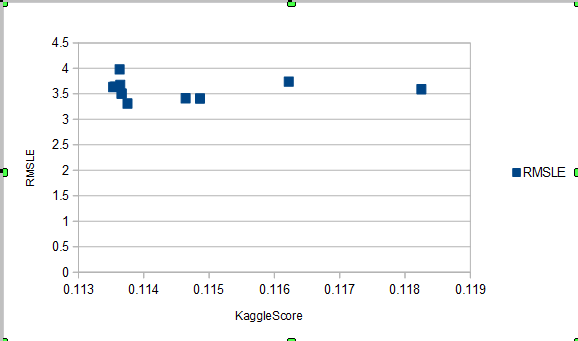

**Ensemble prediction:**

when deciding which models to include in an ensemble:  
    fewer are better  
    more diverse are better  

In [ ]:
ensemble = stacked_pred*stk + xgb_pred*xgb + lgb_pred*lgb  # if using averaged_pred, need to add averaged_pred here

In [ ]:
print(lgb_pred)
print(xgb_pred)
print(stacked_pred)
print(averaged_pred)
print(ensemble)

In [ ]:
print(y_train,stacked_train_pred * stk + xgb_train_pred * xgb + lgb_train_pred * lgb) # if using averaged_pred, need to add averaged_pred here

print(y_train,stacked_train_pred)

**Create File for Submission to Kaggle**

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

In [ ]:
sub.head()

In [ ]:
!pwd

In [ ]:
ls -arlt

In [ ]:
!head -10 submission.csv

In [ ]:
print("Start: ", StartTime)
print("End: ", datetime.datetime.now())